In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from sklearn.impute import SimpleImputer
from scipy.stats import zscore


In [46]:
df = pd.read_csv("/users/yye45/data/yye45/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515")
df.head()

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num
0,0,0,0,0,0,5000+,1,517.81,517.81,2024-08-01,...,1882.21,4.0,470.5525,535.92,400.77,NaN,NaN,0,0,8
1,2,0,0,2,1,0-1000,1,150.00,150.00,2024-04-25,...,150.00,1.0,150.0000,150.00,150.00,NaN,NaN,0,0,4
2,3,0,0,3,0,5000+,0,2603.24,2451.00,2024-03-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3
3,4,0,0,4,1,5000+,0,770.00,770.00,2024-11-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,11
4,7,0,0,7,1,2000-5000,2,10776.63,145.00,2024-05-29,...,7860.00,1.0,7860.0000,7860.00,7860.00,NaN,NaN,0,0,5


In [47]:
#df_prevtran = df[['prevtran1', 'prevtran2','prevtran3','prevtran4','prevtran5','prevtran6','prevtran7','prevtran8','prevtran9','prevtran10']]


prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
df_prevtran = df[prevtran_cols]
df_prevtran


prevtran_cols = [f'prevtrandate{i}' for i in range(1, 11)]
df_prevtran_date = df[prevtran_cols]
df_prevtran_date

,prevtrandate1,prevtrandate2,prevtrandate3,prevtrandate4,prevtrandate5,prevtrandate6,prevtrandate7,prevtrandate8,prevtrandate9,prevtrandate10
0,9.0,9.0,20.0,30.0,30.0,37.0,44.0,52.0,52.0,58.0
1,65.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,87.0,123.0,162.0,172.0,172.0,172.0,253.0,NaN,NaN,NaN
4,16.0,16.0,16.0,16.0,20.0,20.0,20.0,20.0,20.0,20.0
...,...,...,...,...,...,...,...,...,...,...
17760,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17761,9.0,22.0,43.0,61.0,86.0,92.0,112.0,160.0,219.0,NaN
17762,25.0,25.0,42.0,62.0,62.0,78.0,92.0,130.0,130.0,147.0
17763,47.0,87.0,111.0,117.0,117.0,122.0,167.0,189.0,213.0,213.0


In [48]:
# missing value: fill with 0

def prevtran_missing_imputation(df, flag="zero"):
    if flag == "zero":
        prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
        imputer = SimpleImputer(strategy='constant', fill_value=0)
        df[prevtran_cols] = imputer.fit_transform(df[prevtran_cols])
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'zero' is supported.")


def prevtrandate_missing_imputation(df, flag="prevdate"):

    if flag == "prevdate":
        def impute_prevtrandate(row):
            # Find the last available value (starting from 10 to 1)
            for i in reversed(range(10)):
                val = row[prevtrandate_cols[i]]
                if not pd.isna(val):
                    return row.fillna(val)
            return row.fillna(0)

        prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
        df[prevtrandate_cols] = df[prevtrandate_cols].apply(impute_prevtrandate, axis=1)
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'prevdate' is supported.")


def check_prevtran_imputed(df):
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    cols_to_check = prevtran_cols + prevtrandate_cols

    missing = df[cols_to_check].isnull().any()
    return not missing.any()



In [49]:
# Final version of generate_custom_prevtran_features_v2 that fixes rolling with valid_count >= 2

def generate_custom_prevtran_features_v2(df):
    from scipy.stats import zscore
    import numpy as np
    from sklearn.impute import SimpleImputer

    # Step 0: Define column names
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    zscore_cols = [f'z_prevtran{i}' for i in range(1, 11)]

    # Step 1: Apply imputation
    prevtran_missing_imputation(df)
    prevtrandate_missing_imputation(df)
    assert check_prevtran_imputed(df), "Missing values still present after imputation."

    # Step 2: Z-score
    zscore_values = df[prevtran_cols].apply(
        lambda row: zscore(row.values) if np.std(row.values) > 0 else np.zeros(len(row)),
        axis=1, result_type='expand'
    )
    zscore_values.columns = zscore_cols
    df[zscore_cols] = zscore_values

    # Step 3: build valid_mask and rolling valid_count
    valid_mask = df[prevtran_cols].ne(0).astype(int)
    df['z_rolling_valid_count_3'] = valid_mask[[f'prevtran{i}' for i in range(1, 4)]].sum(axis=1)
    df['z_rolling_valid_count_5'] = valid_mask[[f'prevtran{i}' for i in range(1, 6)]].sum(axis=1)

    # Step 4: rolling mean/std only if valid_count >= 2
    df['z_rolling_mean_3'] = np.where(
        df['z_rolling_valid_count_3'] >= 2,
        df[[f'z_prevtran{i}' for i in range(1, 4)]].replace(0, np.nan).mean(axis=1),
        np.nan
    )
    df['z_rolling_std_3'] = np.where(
        df['z_rolling_valid_count_3'] >= 2,
        df[[f'z_prevtran{i}' for i in range(1, 4)]].replace(0, np.nan).std(axis=1),
        np.nan
    )
    df['z_rolling_mean_5'] = np.where(
        df['z_rolling_valid_count_5'] >= 2,
        df[[f'z_prevtran{i}' for i in range(1, 6)]].replace(0, np.nan).mean(axis=1),
        np.nan
    )
    df['z_rolling_std_5'] = np.where(
        df['z_rolling_valid_count_5'] >= 2,
        df[[f'z_prevtran{i}' for i in range(1, 6)]].replace(0, np.nan).std(axis=1),
        np.nan
    )

    # Step 5: spike detection
    df['z_spike_recent_3'] = (df['z_prevtran1'] > df['z_rolling_mean_3'] + 2).astype(int)
    df['z_spike_recent_5'] = (df['z_prevtran1'] > df['z_rolling_mean_5'] + 2).astype(int)

    # Step 6: z-score differences
    df['z_diff_1_2'] = df['z_prevtran1'] - df['z_prevtran2']
    df['z_diff_2_3'] = df['z_prevtran2'] - df['z_prevtran3']

    # Step 7: gap values
    gap_cols = [f'prevtrandate{i}' for i in range(1, 11)]

    df['gap_std'] = df[gap_cols].std(axis=1)
    df['gap_mean'] = df[gap_cols].mean(axis=1)
    df['gap_median'] = df[gap_cols].median(axis=1)
    df['gap_max'] = df[gap_cols].max(axis=1)
    df['gap_min'] = df[gap_cols].min(axis=1)

    # gap的集中度: 短期爆发可能是fraud
    #df['gap_pct_short'] = (df[gap_cols] < 5).sum(axis=1) / 10
    short_threshold = df[gap_cols].stack().quantile(0.25)  # bottom 25% gap
    df['gap_pct_short_q25'] = (df[gap_cols] < short_threshold).sum(axis=1) / len(gap_cols)


    # Step 8: Total time span
    #df['prevtrandate_span'] = df[prevtrandate_cols].max(axis=1) - df[prevtrandate_cols].min(axis=1)
    df['log_prevtrandate_span'] = np.log1p(df[prevtrandate_cols].max(axis=1) - df[prevtrandate_cols].min(axis=1))

    return df



df_fe = generate_custom_prevtran_features_v2(df)
df_fe

/tmp/ipykernel_3217053/1475401571.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda row: zscore(row.values) if np.std(row.values) > 0 else np.zeros(len(row)),
/tmp/ipykernel_3217053/1475401571.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda row: zscore(row.values) if np.std(row.values) > 0 else np.zeros(len(row)),
/tmp/ipykernel_3217053/1475401571.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lambda row: zscore(row.values) if np.std(row.values) > 0 else np.zeros(len(row)),
/tmp/ipykernel_3217053/1475401571.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to ca

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,z_spike_recent_5,z_diff_1_2,z_diff_2_3,gap_std,gap_mean,gap_median,gap_max,gap_min,gap_pct_short_q25,log_prevtrandate_span
0,0,0,0,0,0,5000+,1,517.81,517.81,2024-08-01,...,0,-0.216111,0.724981,17.672640,34.1,33.5,58.0,9.0,0.0,3.912023
1,2,0,0,2,1,0-1000,1,150.00,150.00,2024-04-25,...,0,0.000000,2.500000,1.897367,70.4,71.0,71.0,65.0,0.0,1.945910
2,3,0,0,3,0,5000+,0,2603.24,2451.00,2024-03-18,...,0,3.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,4,0,0,4,1,5000+,0,770.00,770.00,2024-11-29,...,0,2.707065,-0.304569,60.304781,190.0,172.0,253.0,87.0,0.0,5.117994
4,7,0,0,7,1,2000-5000,2,10776.63,145.00,2024-05-29,...,0,-1.426794,1.929026,2.065591,18.4,20.0,20.0,16.0,0.0,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17760,8473,6,0,9812,0,5000+,2,2000.00,2000.00,2024-11-05,...,0,3.333333,0.000000,0.000000,15.0,15.0,15.0,15.0,0.0,0.000000
17761,13065,0,0,15652,1,0-1000,1,5000.00,5000.00,2024-11-06,...,0,0.000000,0.000000,75.577848,102.3,89.0,219.0,9.0,0.0,5.351858
17762,5415,0,1,6062,17,5000+,0,4000.00,2000.00,2024-11-12,...,0,0.000000,2.107719,44.439847,79.3,70.0,147.0,25.0,0.0,4.812184
17763,16147,0,0,19785,1,5000+,0,3000.00,3000.00,2024-11-18,...,0,-0.623853,0.000000,55.216845,138.3,119.5,213.0,47.0,0.0,5.117994


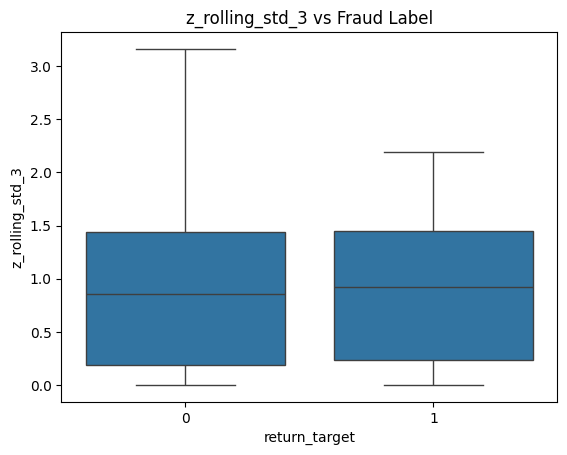

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# 例如看 rolling std 是否高 → fraud 比例高
sns.boxplot(data=df, x='return_target', y='z_rolling_std_3')
plt.title('z_rolling_std_3 vs Fraud Label')
plt.show()

# Fraud 用户的交易行为更加一致、模式化，缺乏剧烈波动。

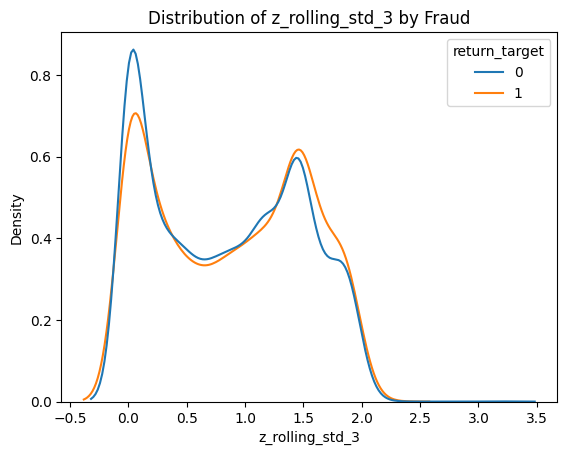

In [51]:
import seaborn as sns
sns.kdeplot(data=df_fe, x='z_rolling_std_3', hue='return_target', common_norm=False)
plt.title("Distribution of z_rolling_std_3 by Fraud")
plt.show()


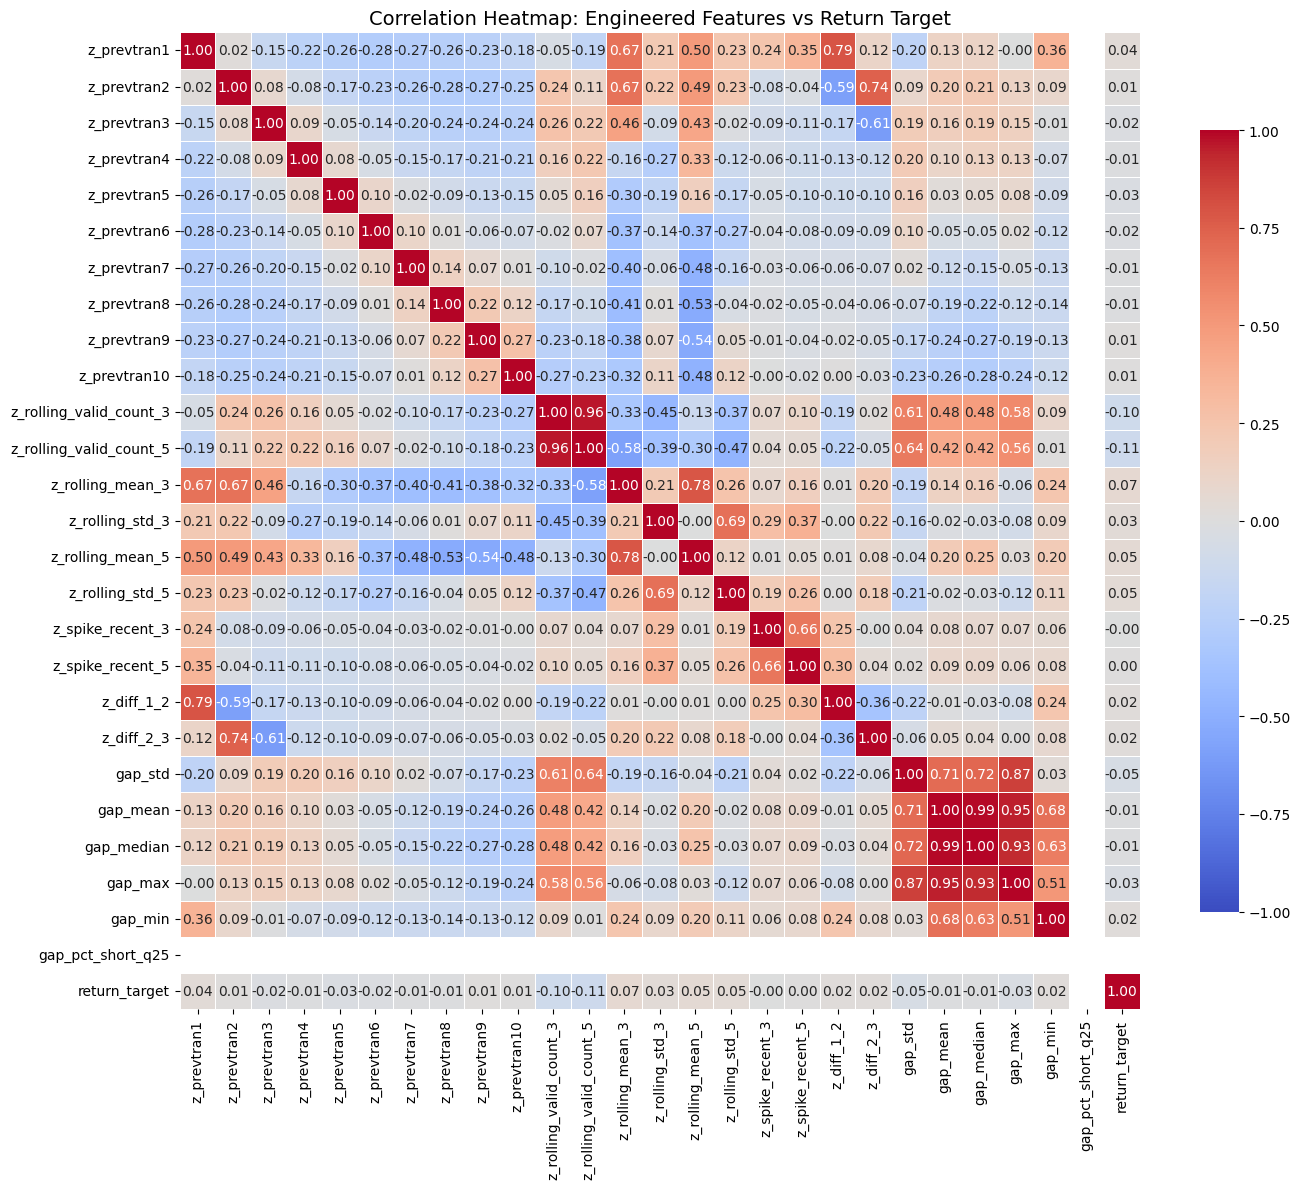

In [52]:
engineered_features = [col for col in df_fe.columns if col.startswith(('z_', 'gap_', 'prevtrandate_span'))]
corr_df = df_fe[engineered_features + ['return_target']]
corr_matrix = corr_df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap: Engineered Features vs Return Target", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [53]:
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.feature_selection import mutual_info_classif

# Update function to include newly engineered gap features
def run_best_statistical_test_per_feature(df, target_col='return_target'):
    target = df[target_col]
    
    # Include all z_*, gap_*, and prevtrandate_* features (except date 1-10 raw)
    feature_cols = [col for col in df.columns if col.startswith(('z_', 'gap_', 'log_prevtrandate_span')) and not col.startswith('prevtrandate') or col == 'prevtrandate_span']
    
    # Calculate Mutual Information
    X_mi = df[feature_cols].fillna(0)
    mi_scores = mutual_info_classif(X_mi, target, discrete_features=False)

    results = []

    for i, col in enumerate(feature_cols):
        feature = df[col]
        result = {"Feature": col}
        x0 = feature[df[target_col] == 0].dropna()
        x1 = feature[df[target_col] == 1].dropna()

        # Decide test by type
        unique_vals = set(feature.dropna().unique())
        if unique_vals.issubset({0, 1}):
            # Binary feature → Chi-square
            try:
                contingency = pd.crosstab(feature, target)
                chi2, pval, _, _ = chi2_contingency(contingency)
                result['Test'] = 'Chi-square'
                result['p-value'] = pval
            except:
                result['Test'] = 'Chi-square'
                result['p-value'] = None
        else:
            # Continuous → U Test
            try:
                _, pval = mannwhitneyu(x0, x1, alternative='two-sided')
                result['Test'] = 'Mann–Whitney U'
                result['p-value'] = pval
            except:
                result['Test'] = 'Mann–Whitney U'
                result['p-value'] = None

        result['Mutual Info'] = mi_scores[i]
        results.append(result)

    return pd.DataFrame(results).sort_values('p-value')

# Execute updated test analysis
test_results = run_best_statistical_test_per_feature(df_fe)
test_results

,Feature,Test,p-value,Mutual Info
11,z_rolling_valid_count_5,Mann–Whitney U,1.234035e-52,0.012076
10,z_rolling_valid_count_3,Mann–Whitney U,6.103286e-46,0.012823
26,log_prevtrandate_span,Mann–Whitney U,2.702973e-32,0.008792
20,gap_std,Mann–Whitney U,3.725717e-32,0.004322
23,gap_max,Mann–Whitney U,3.185869e-17,0.012128
21,gap_mean,Mann–Whitney U,3.503403e-12,0.006738
12,z_rolling_mean_3,Mann–Whitney U,4.624841e-12,0.008468
22,gap_median,Mann–Whitney U,5.829685e-12,0.007972
14,z_rolling_mean_5,Mann–Whitney U,3.453417e-07,0.007263
15,z_rolling_std_5,Mann–Whitney U,3.916775e-07,0.007300


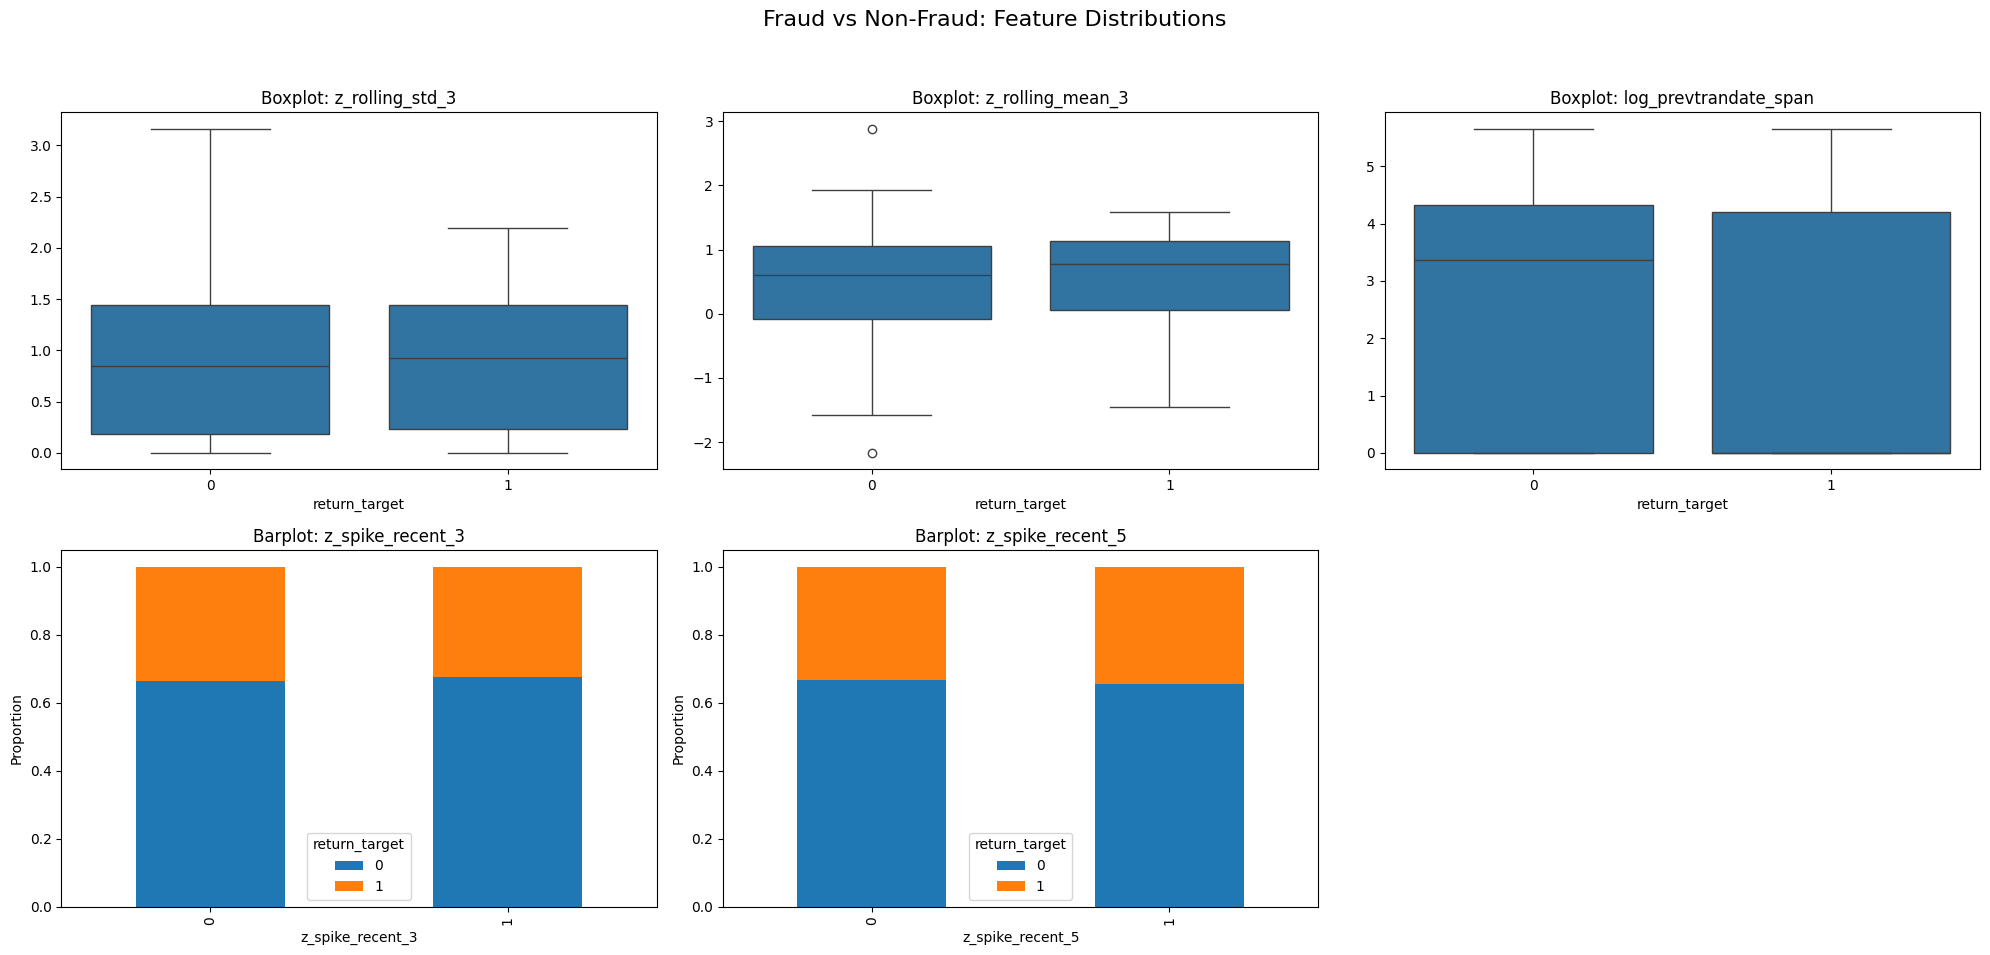

In [54]:

# Step 1: Define feature groups
binary_features = ['z_spike_recent_3', 'z_spike_recent_5']
boxplot_features = ['z_rolling_std_3', 'z_rolling_mean_3', 'log_prevtrandate_span']

# Create plots
fig, axes = plt.subplots(2, len(boxplot_features), figsize=(20, 10))
fig.suptitle("Fraud vs Non-Fraud: Feature Distributions", fontsize=16)

# Top row: Boxplots for continuous features
for i, feature in enumerate(boxplot_features):
    if feature in df_fe.columns:
        sns.boxplot(data=df_fe, x='return_target', y=feature, ax=axes[0, i])
        axes[0, i].set_title(f"Boxplot: {feature}")
        axes[0, i].set_xlabel("return_target")
        axes[0, i].set_ylabel("")

# Bottom row: Barplots for binary features
for i, feature in enumerate(binary_features):
    if feature in df_fe.columns:
        ct = pd.crosstab(df_fe[feature], df_fe['return_target'], normalize='index')
        ct.plot(kind='bar', stacked=True, ax=axes[1, i])
        axes[1, i].set_title(f"Barplot: {feature}")
        axes[1, i].set_xlabel(f"{feature}")
        axes[1, i].set_ylabel("Proportion")

# Hide unused subplot (if any)
for j in range(len(binary_features), len(boxplot_features)):
    fig.delaxes(axes[1, j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


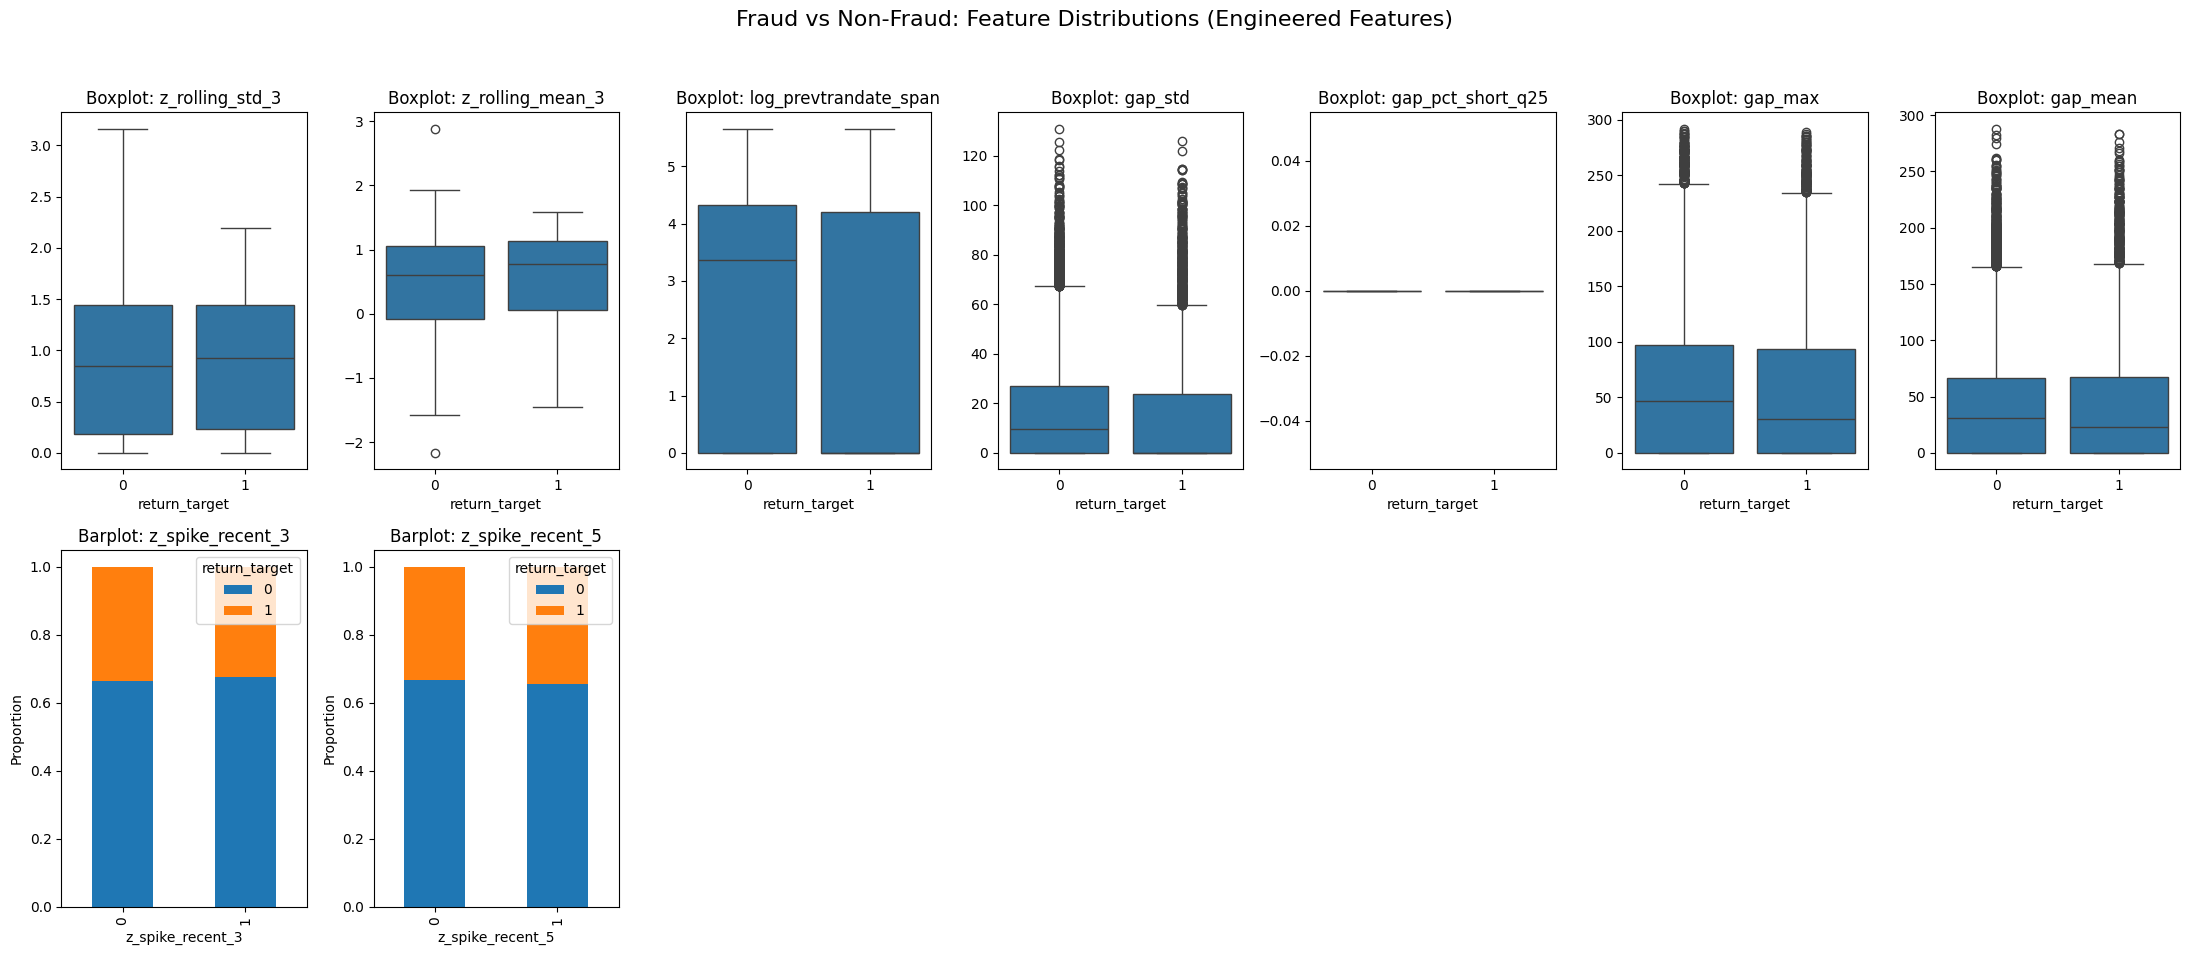

In [55]:
# Include newly engineered features with strong signals
binary_features = ['z_spike_recent_3', 'z_spike_recent_5']
boxplot_features = [
    'z_rolling_std_3', 'z_rolling_mean_3', 'log_prevtrandate_span',
    'gap_std', 'gap_pct_short_q25', 'gap_max', 'gap_mean'
]

# Create plot grid
fig, axes = plt.subplots(2, len(boxplot_features), figsize=(22, 10))
fig.suptitle("Fraud vs Non-Fraud: Feature Distributions (Engineered Features)", fontsize=16)

# Top row: Boxplots for continuous features
for i, feature in enumerate(boxplot_features):
    if feature in df_fe.columns:
        sns.boxplot(data=df_fe, x='return_target', y=feature, ax=axes[0, i])
        axes[0, i].set_title(f"Boxplot: {feature}")
        axes[0, i].set_xlabel("return_target")
        axes[0, i].set_ylabel("")

# Bottom row: Barplots for binary features
for i, feature in enumerate(binary_features):
    if feature in df_fe.columns:
        ct = pd.crosstab(df_fe[feature], df_fe['return_target'], normalize='index')
        ct.plot(kind='bar', stacked=True, ax=axes[1, i])
        axes[1, i].set_title(f"Barplot: {feature}")
        axes[1, i].set_xlabel(f"{feature}")
        axes[1, i].set_ylabel("Proportion")

# Hide unused subplot (if any)
for j in range(len(binary_features), len(boxplot_features)):
    fig.delaxes(axes[1, j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


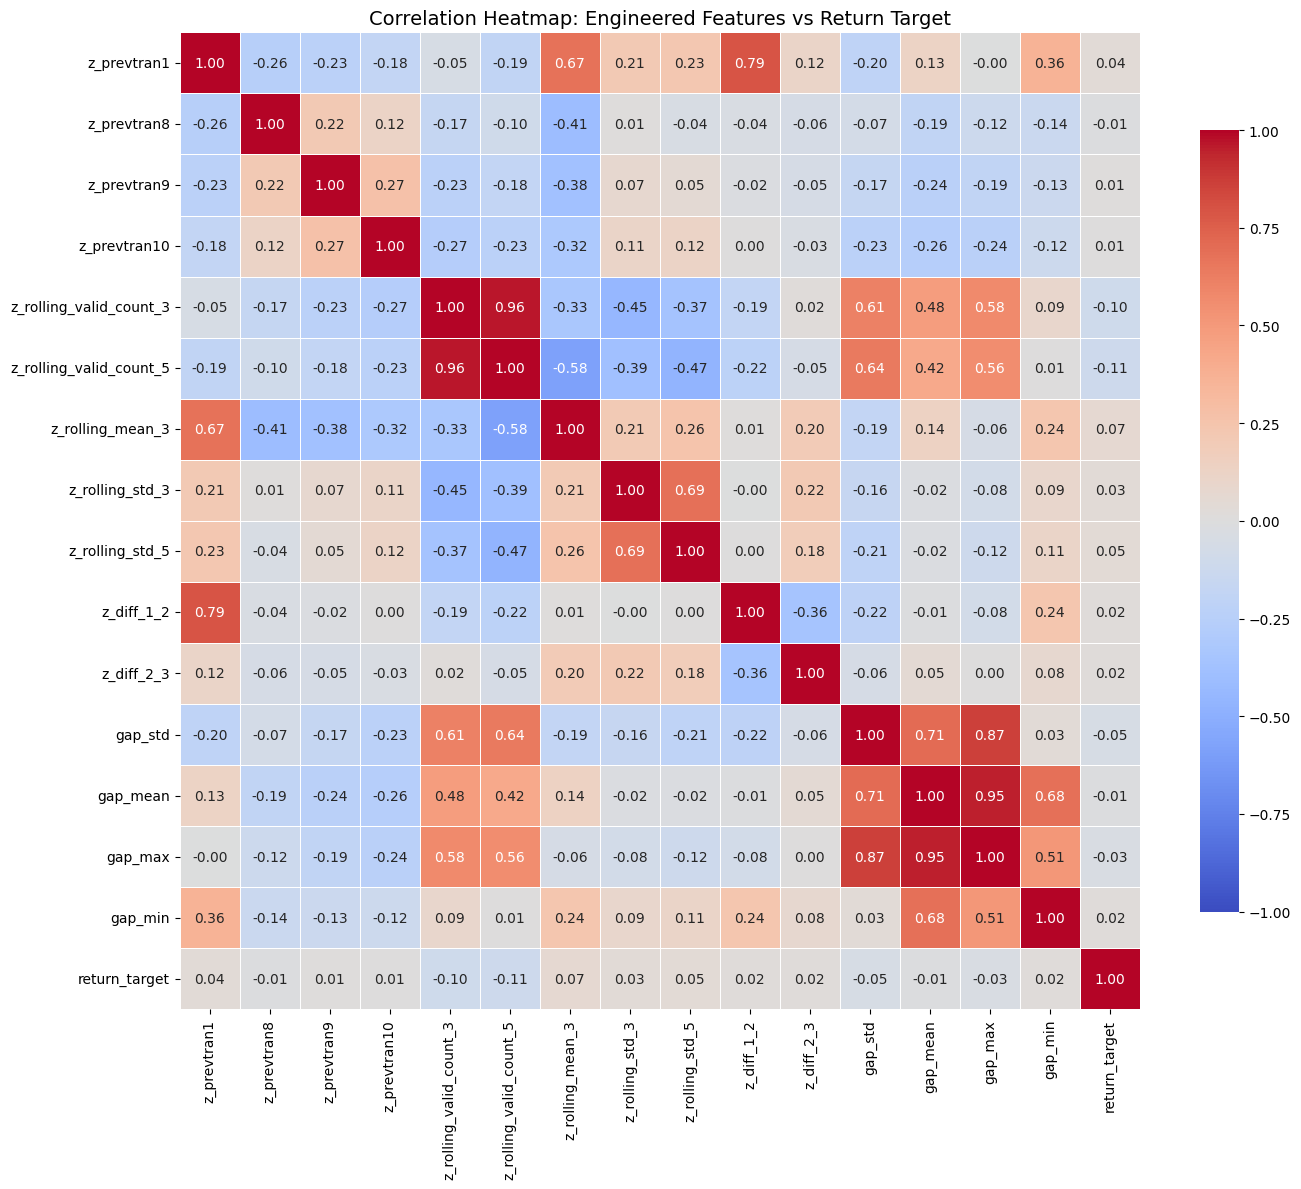

In [60]:
# Features to drop based on correlation, redundancy, or lack of signal
drop_features = [
    'z_prevtran2', 'z_prevtran3','z_prevtran4', 'z_prevtran5','z_prevtran6', 'z_prevtran7',
    'z_spike_recent_5','z_spike_recent_3',
    'gap_pct_short_q25', 'gap_median', #'gap_diff_1_2'
    'z_rolling_mean_5'  # highly correlated with mean_3
]

# Drop them from the DataFrame
df_fe_reduced = df_fe.drop(columns=drop_features)

# Retain only useful engineered features
selected_features = [
    'z_prevtran1', 'z_prevtran10', 'z_diff_2_3',
    'z_rolling_std_3', 'z_rolling_mean_3',
    'log_prevtrandate_span', 'gap_std', 'gap_max', #'gap_mean',
    'z_spike_recent_3', 'z_rolling_valid_count_3', 'z_rolling_valid_count_5'
]
#X_selected = df_fe_reduced[selected_features]


engineered_features = [col for col in df_fe_reduced.columns if col.startswith(('z_', 'gap_', 'prevtrandate_span'))]
corr_df = df_fe_reduced[engineered_features + ['return_target']]
corr_matrix = corr_df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap: Engineered Features vs Return Target", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [62]:
test_results_new = run_best_statistical_test_per_feature(df_fe_reduced)
test_results_new

,Feature,Test,p-value,Mutual Info
5,z_rolling_valid_count_5,Mann–Whitney U,1.234035e-52,0.007698
4,z_rolling_valid_count_3,Mann–Whitney U,6.103286e-46,0.011499
15,log_prevtrandate_span,Mann–Whitney U,2.702973e-32,0.011746
11,gap_std,Mann–Whitney U,3.725717e-32,0.004281
13,gap_max,Mann–Whitney U,3.185869e-17,0.004904
12,gap_mean,Mann–Whitney U,3.503403e-12,0.009968
6,z_rolling_mean_3,Mann–Whitney U,4.624841e-12,0.009642
8,z_rolling_std_5,Mann–Whitney U,3.916775e-07,0.004895
14,gap_min,Mann–Whitney U,2.750702e-05,0.010004
0,z_prevtran1,Mann–Whitney U,1.283755e-04,0.008014


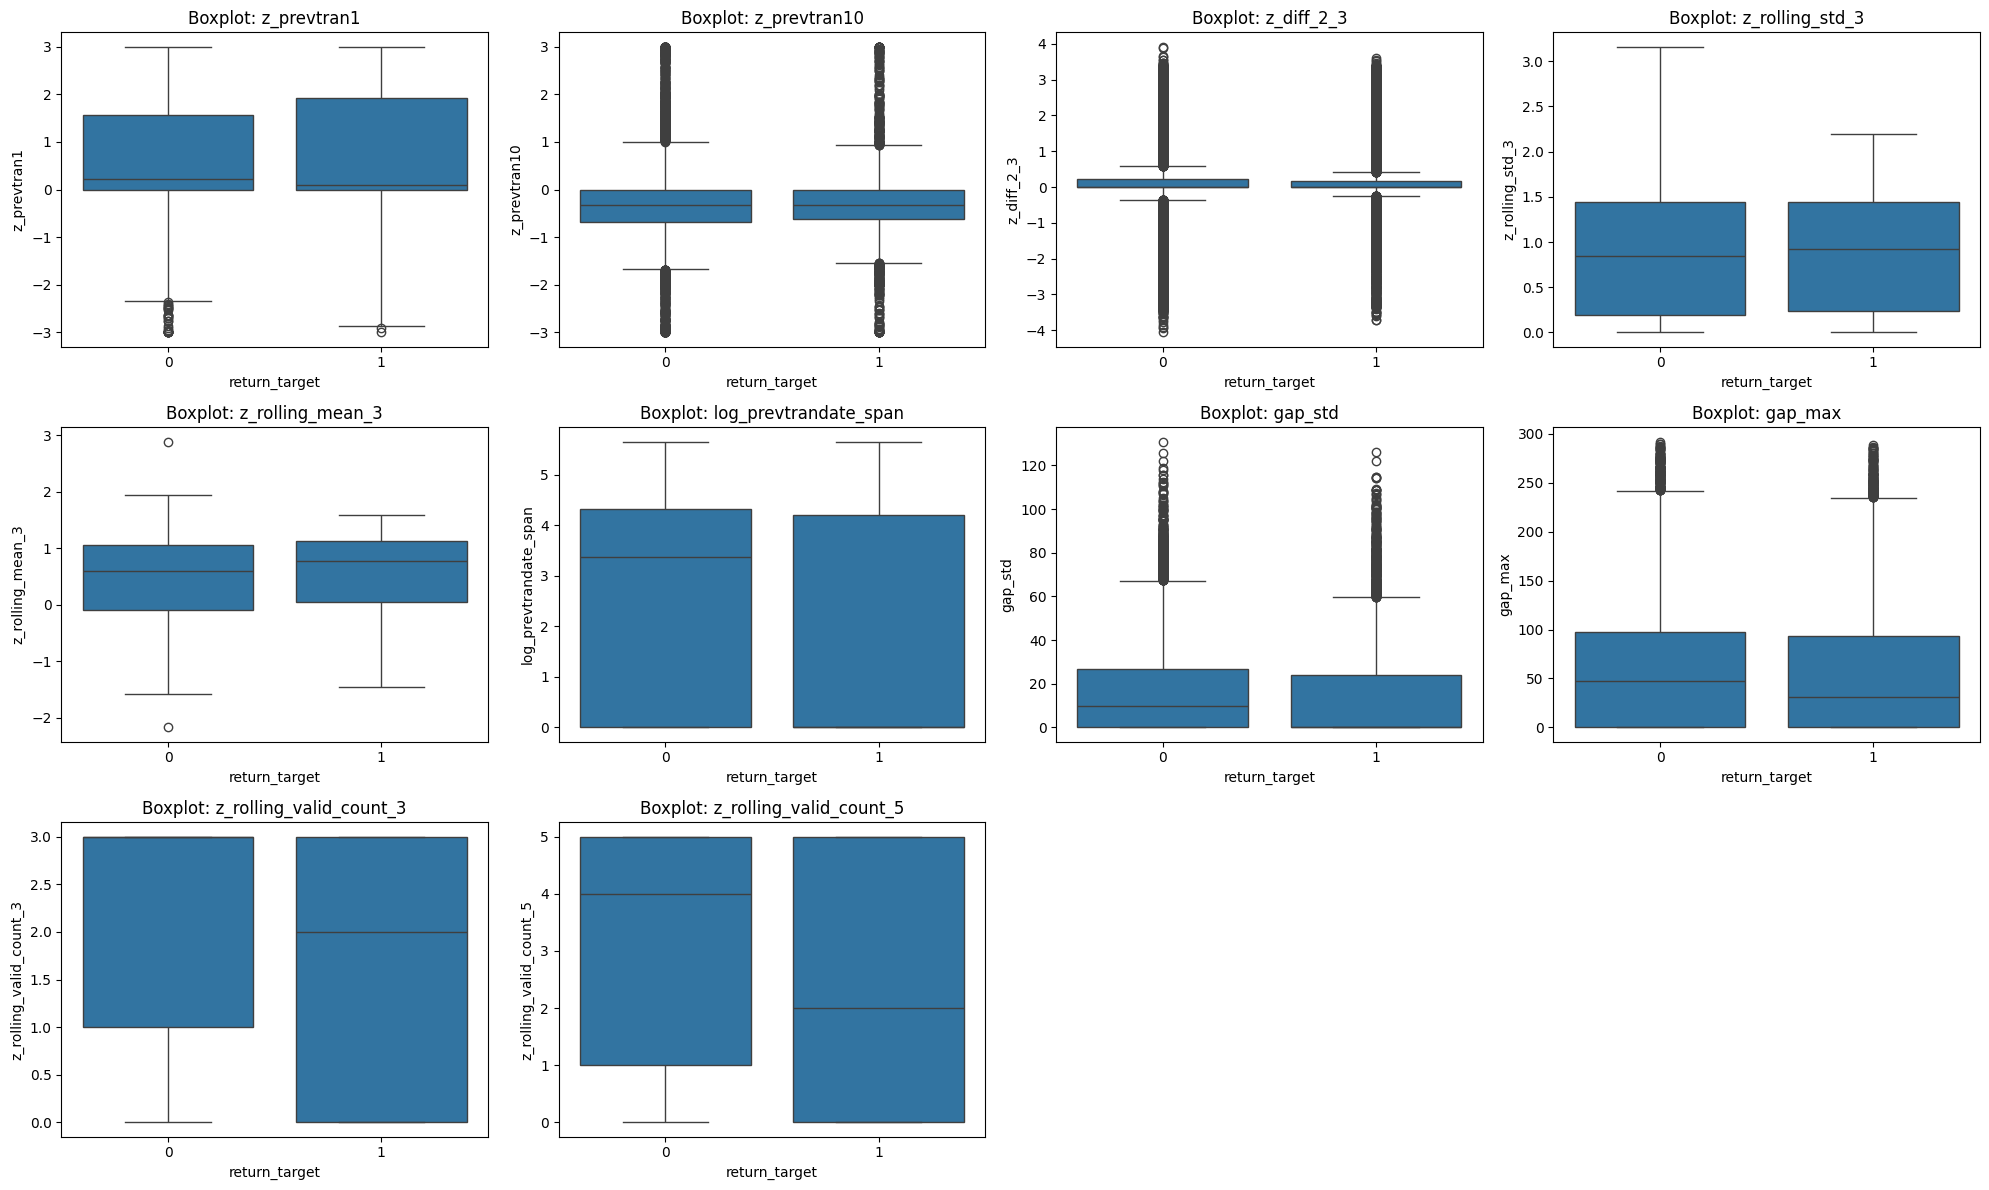

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the reduced feature set (from df_fe_reduced)
selected_features = [
    'z_prevtran1', 'z_prevtran10', 'z_diff_2_3',
    'z_rolling_std_3', 'z_rolling_mean_3',
    'log_prevtrandate_span', 'gap_std', 'gap_max', #'gap_mean',
     'z_rolling_valid_count_3', 'z_rolling_valid_count_5'# 'z_spike_recent_3',
]

# Separate features for plotting
boxplot_feats = [f for f in selected_features if df_fe_reduced[f].nunique() > 2]
barplot_feats = [f for f in selected_features if df_fe_reduced[f].nunique() == 2]

# Create plots
n = len(boxplot_feats) + len(barplot_feats)
ncols = 4
nrows = -(-n // ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

# Plot boxplots
idx = 0
for feature in boxplot_feats:
    sns.boxplot(data=df_fe_reduced, x='return_target', y=feature, ax=axes[idx])
    axes[idx].set_title(f'Boxplot: {feature}')
    idx += 1

# Plot barplots for binary features
for feature in barplot_feats:
    ct = pd.crosstab(df_fe_reduced[feature], df_fe_reduced['return_target'], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=axes[idx])
    axes[idx].set_title(f'Barplot: {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Proportion')
    idx += 1

# Hide unused subplots
while idx < len(axes):
    fig.delaxes(axes[idx])
    idx += 1

plt.tight_layout()
plt.show()


## 🧹 Dropped Features Summary

### ✅ Transaction Amounts (`prevtran*`)
| Feature         | Reason for Removal |
|----------------|--------------------|
| `prevtran7`    | Highly correlated with `prevtran6` (`corr ≈ 0.91`) |
| `prevtran8`    | Highly correlated with `prevtran7` |
| `prevtran9`    | Highly correlated with `prevtran8` |
| `prevtran10`   | Highly correlated with `prevtran9` |

> 🔁 Only `prevtran1` to `prevtran6` are retained to reduce multicollinearity.

---

### 📅 Transaction Dates (`prevtrandate*`)
| Feature            | Reason for Removal |
|--------------------|--------------------|
| `prevtrandate4`–`prevtrandate10` | Strong inter-correlation (`corr > 0.95`) — only first 3 retained |
| `prevtrandate_span` | Replaced by `log_prevtrandate_span` for smoother scale & distribution |
| `gap_diff_1_2`, `gap_diff_2_3` | Misinterpreted gap logic + no clear performance gain |

---

### 📊 Statistical Aggregates
| Feature           | Reason for Removal |
|------------------|--------------------|
| `prevtran_median` | Highly correlated with `prevtran_mean` (`corr = 0.96`) |
| `pacf_lag1`       | Perfectly correlated with `acf_lag1` |

---

### 📉 Gaps
| Feature           | Reason for Removal |
|------------------|--------------------|
| `gap_mean`        | Very high correlation with `gap_std` and `gap_max` (`corr > 0.95`) |
| `gap_pct_short`   | Mostly zero values, not informative |
| `gap_pct_short_q25` | Even less variance and discriminatory power |

---

### ⚠️ Spike & Ratio Features
| Feature             | Reason for Removal |
|--------------------|--------------------|
| `z_spike_recent_3` | Chi-square p = 0.71 → no significant difference |
| `z_spike_recent_5` | Chi-square p = 0.60, flat distributions |
| `z_diff_1_2`       | Weak effect size, minimal improvement |
| `z_diff_2_3`       | Redundant with z-score window statistics |

---

## 📌 Summary Explanation

To improve model performance and interpretability, we dropped features that are:

- **Highly correlated** with other stronger variables (e.g., `prevtran10` ≈ `prevtran9`)
- **Statistically insignificant**, with high p-values in Mann–Whitney U or Chi-square tests
- **Low mutual information**, indicating weak predictive contribution
- **Semantically redundant or incorrectly defined** (e.g., time gaps that don't reflect the actual transaction structure)

This step reduced dimensionality and multicollinearity while preserving core patterns related to **recent transaction behavior**, **rolling consistency**, and **temporal activity bursts**.

---


z_prevtran1 / z_diff_2_3 / z_rolling_mean_3：没有很有效

In [ ]:
from scipy.stats import ks_2samp

x0 = df_fe.loc[df_fe['return_target'] == 0, 'z_rolling_std_3']
x1 = df_fe.loc[df_fe['return_target'] == 1, 'z_rolling_std_3']

ks_stat, ks_p = ks_2samp(x0.dropna(), x1.dropna())
print(f"KS Test: stat = {ks_stat:.4f}, p = {ks_p:.5f}")


KS Test: stat = 0.0405, p = 0.00105


In [ ]:
from scipy.stats import mannwhitneyu

feature = 'z_rolling_std_3'

# 去掉缺失值
x0 = df_fe.loc[(df_fe['return_target'] == 0) & (~df_fe[feature].isna()), feature]
x1 = df_fe.loc[(df_fe['return_target'] == 1) & (~df_fe[feature].isna()), feature]

stat, p_value = mannwhitneyu(x0, x1, alternative='two-sided')
print(f"Mann-Whitney U Test for {feature}: p = {p_value:.5f}, stat = {stat}")


Mann-Whitney U Test for z_rolling_std_3: p = 0.00038, stat = 12003378.0


In [66]:
from scipy.stats import chi2_contingency
pd.crosstab(df_fe['z_spike_recent_3'], df_fe['return_target'])

chi2, p, _, _ = chi2_contingency(pd.crosstab(df_fe['z_spike_recent_3'], df_fe['return_target']))
print(f"Chi-square p-value: {p:.5f}")


Chi-square p-value: 0.71192
